In [1]:
# ------------------------------
# STEP 1: Import Libraries and Setup2c
# ------------------------------
!pip install apscheduler
!pip install --upgrade scikit-learn # install the missing package
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import os
import logging
import time
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
from IPython.display import display, clear_output
from apscheduler.schedulers.background import BackgroundScheduler

logging.basicConfig(filename='pipeline_log.txt', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

BASE_URL = "https://api.sensade.com/opendata/parkinglots/occupancy"
HEADERS = {"accept": "application/json"}
YEAR = 2025
WEEK = datetime.utcnow().isocalendar().week

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 1.4 MB/s eta 0:00:00


In [2]:
# ------------------------------
# STEP 2: Get All Lots from API (Dynamic Discovery)
# ------------------------------
def fetch_all_known_lots():
    try:
        url = "https://api.sensade.com/opendata/organizations/708ba229-a862-45c2-bebe-d17fbeeaa340/parkingLots"
        response = requests.get(url, headers=HEADERS)
        if response.status_code == 200:
            lots = response.json()
            known_lots = [(lot["id"], lot["name"]) for lot in lots if "id" in lot and "name" in lot]
            print(f"Dynamically fetched {len(known_lots)} lots from Sensade API")
            print("🔍 Preview:")
            for lot in known_lots[:5]:
                print(f"- {lot[1]} ({lot[0]})")
            return known_lots
        else:
            logging.error(f"Failed to fetch lots. Status code: {response.status_code}")
            return []
    except Exception as e:
        logging.error(f"Error fetching lots: {e}")
        return []

In [3]:
# ------------------------------
# STEP 2: Find Active Lots by Checking API Response
# ------------------------------
def get_active_lots(all_known_lots, week=WEEK, year=YEAR):
    import requests
    import logging

    print("🚀 Running get_active_lots...")
    active = []
    print("🔍 Checking for active lots...")

    for i, (lot_id, name) in enumerate(all_known_lots, 1):
        try:
            print(f"Checking {i}/{len(all_known_lots)}: {name}...")
            r = requests.get(BASE_URL, headers=HEADERS, params={
                "LotId": lot_id,
                "Year": year,
                "WeekNumber": week
            }, timeout=10)

            if r.status_code == 200 and r.json().get("data"):
                active.append({"id": lot_id, "name": name})
        except Exception as e:
            print(f"Error checking lot {name}: {e}")
            logging.error(f"Error checking lot {name}: {e}")
            continue

    if active:
        print("\nActive Lots:")
        for lot in active:
            print(f"- {lot['name']} ({lot['id']})")
    else:
        print("No active lots found for this week.")

    return active

In [4]:
#Get the All Active Lots
all_lots = fetch_all_known_lots()
active_lots = get_active_lots(all_lots)

Dynamically fetched 33 lots from Sensade API
🔍 Preview:
- Ole Rømers Gade 38-50 (02e71643-9263-4ac9-9b9d-efe634811bd0)
- Ingerslev Boulevard Parkeringsplads Øst (10a7085b-e70d-4a98-9f13-624324ebed0e)
- Sankt Anna Gade 24-41 (147d53da-ca58-4f2d-85c1-fa4c78145c9f)
- Montanagade 43-57 (18f4f0e6-d797-41bb-803a-a6f1d29ad833)
- Ingerslevs Boulevard 15-31 (21f9f0d5-4710-4b9b-b51a-0477f77c8ff4)
🚀 Running get_active_lots...
🔍 Checking for active lots...
Checking 1/33: Ole Rømers Gade 38-50...
Checking 2/33: Ingerslev Boulevard Parkeringsplads Øst...
Checking 3/33: Sankt Anna Gade 24-41...
Checking 4/33: Montanagade 43-57...
Checking 5/33: Ingerslevs Boulevard 15-31...
Checking 6/33: Ole Rømers Gade 62A-76A...
Checking 7/33: Vejlegade 3-11...
Checking 8/33: Dannebrogsgade 19-35...
Checking 9/33: Ole Rømers Gade 56-60...
Checking 10/33: Ingerslev Boulevard 14-24...
Checking 11/33: Ingerslev Boulevard Parkeringsplads Vest...
Checking 12/33: Ingerslev Boulevard (Sankt Lukas Kirke)...
Checking 13/33

In [5]:
# ------------------------------
# STEP 3: Real-Time Hourly Data Logging
# ------------------------------
def log_realtime_data(active_lots):
    all_data = []
    for lot in active_lots:
        try:
            r = requests.get(BASE_URL, headers=HEADERS, params={"LotId": lot["id"]}, timeout=10)
            if r.status_code == 200:
                for ts, usage in r.json().get("data", {}).items():
                    all_data.append({
                        "timestamp": ts,
                        "lot_id": lot["id"],
                        "lot_name": lot["name"],
                        "curb_occupancy": usage.get("curb"),
                        "handicap_occupancy": usage.get("handicap")
                    })
        except Exception as e:
            logging.error(f"Error logging real-time data for lot {lot['name']}: {e}")
            continue

    df = pd.DataFrame(all_data)
    if not df.empty:
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        df = df.drop_duplicates(subset=["timestamp", "lot_id"])

        # Save or append data to CSV file
        filename = f"realtime_occupancy_week_{WEEK}_{YEAR}.csv"
        if os.path.exists(filename):
            df_existing = pd.read_csv(filename)
            df_existing["timestamp"] = pd.to_datetime(df_existing["timestamp"])
            df = pd.concat([df_existing, df], ignore_index=True)
            df = df.drop_duplicates(subset=["timestamp", "lot_id"])

        df.to_csv(filename, index=False)

        print("\nReal-time Data (Preview):")
        display(df.head())
        print(f"Data saved: {filename}")
    else:
        print("No real-time data available.")

    return df


In [6]:
# Run Step 4 to fetch and view real-time occupancy data
df_realtime = log_realtime_data(active_lots)

# Display the first few rows
df_realtime.head()

df_realtime.to_csv("realtime_occupancy_week_19_2025.csv", index=False)

ERROR:root:Error logging real-time data for lot Ingerslev Boulevard (Sankt Lukas Kirke): HTTPSConnectionPool(host='api.sensade.com', port=443): Read timed out. (read timeout=10)
ERROR:root:Error logging real-time data for lot Sankt Lucas Kirkeplads: HTTPSConnectionPool(host='api.sensade.com', port=443): Read timed out. (read timeout=10)
ERROR:root:Error logging real-time data for lot Godthåbsgade 25-39: HTTPSConnectionPool(host='api.sensade.com', port=443): Read timed out. (read timeout=10)



Real-time Data (Preview):


,timestamp,lot_id,lot_name,curb_occupancy,handicap_occupancy
0,2025-05-26 00:00:00+00:00,02e71643-9263-4ac9-9b9d-efe634811bd0,Ole Rømers Gade 38-50,100.0,0.0
1,2025-05-26 01:00:00+00:00,02e71643-9263-4ac9-9b9d-efe634811bd0,Ole Rømers Gade 38-50,100.0,0.0
2,2025-05-26 02:00:00+00:00,02e71643-9263-4ac9-9b9d-efe634811bd0,Ole Rømers Gade 38-50,100.0,0.0
3,2025-05-26 03:00:00+00:00,02e71643-9263-4ac9-9b9d-efe634811bd0,Ole Rømers Gade 38-50,100.0,0.0
4,2025-05-26 04:00:00+00:00,02e71643-9263-4ac9-9b9d-efe634811bd0,Ole Rømers Gade 38-50,100.0,0.0


Data saved: realtime_occupancy_week_22_2025.csv


In [7]:
# Load new parking data
parking_df = pd.read_csv("realtime_occupancy_week_19_2025.csv")
parking_df['timestamp'] = pd.to_datetime(parking_df['timestamp']).dt.round('h')
parking_df = parking_df.rename(columns={"timestamp": "ds"})
parking_df['date'] = parking_df['ds'].dt.date
parking_df['hour'] = parking_df['ds'].dt.hour
parking_df.head()

,ds,lot_id,lot_name,curb_occupancy,handicap_occupancy,date,hour
0,2025-05-26 00:00:00+00:00,02e71643-9263-4ac9-9b9d-efe634811bd0,Ole Rømers Gade 38-50,100.0,0.0,2025-05-26,0
1,2025-05-26 01:00:00+00:00,02e71643-9263-4ac9-9b9d-efe634811bd0,Ole Rømers Gade 38-50,100.0,0.0,2025-05-26,1
2,2025-05-26 02:00:00+00:00,02e71643-9263-4ac9-9b9d-efe634811bd0,Ole Rømers Gade 38-50,100.0,0.0,2025-05-26,2
3,2025-05-26 03:00:00+00:00,02e71643-9263-4ac9-9b9d-efe634811bd0,Ole Rømers Gade 38-50,100.0,0.0,2025-05-26,3
4,2025-05-26 04:00:00+00:00,02e71643-9263-4ac9-9b9d-efe634811bd0,Ole Rømers Gade 38-50,100.0,0.0,2025-05-26,4


In [9]:
# Load and clean weather and traffic
weather_df = pd.read_csv("weather_data.csv")
weather_df['time'] = pd.to_datetime(weather_df['time']).dt.round('h')
weather_clean = weather_df[['time', 'temp', 'condition']].rename(columns={'time': 'ds'})

traffic_df = pd.read_csv("traffic_congestion.csv")
traffic_df['timestamp'] = pd.to_datetime(traffic_df['timestamp']).dt.tz_localize(None).dt.round('h')
traffic_df['traffic_congestion'] = traffic_df['traffic congestion'].str.replace('%', '').astype(float)
traffic_clean = traffic_df[['timestamp', 'traffic_congestion']].rename(columns={'timestamp': 'ds'})
traffic_df.head()
weather_df.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,condition
0,2025-05-12 00:00:00,5.6,3.8,88.0,0.0,NaN,170.0,2.0,8.0,1021.7,NaN,1.0,Clear
1,2025-05-12 01:00:00,4.0,3.0,93.0,0.0,NaN,210.0,2.0,11.1,1021.0,NaN,2.0,Clear
2,2025-05-12 02:00:00,4.0,2.0,87.0,0.0,NaN,80.0,6.0,11.1,1021.0,NaN,2.0,Clear
3,2025-05-12 03:00:00,3.0,2.0,93.0,0.0,NaN,160.0,2.0,11.1,1021.0,NaN,2.0,Clear
4,2025-05-12 04:00:00,6.0,5.0,93.0,0.0,NaN,160.0,2.0,7.4,1022.0,NaN,1.0,Clear


In [10]:
# Realistic weather sampling
unique_dates = parking_df['date'].unique()
daily_weather_samples = []
for day in unique_dates:
    sample_day = weather_clean['ds'].dt.date.sample(n=1).values[0]
    day_weather = weather_clean[weather_clean['ds'].dt.date == sample_day]
    condition = day_weather['condition'].mode().iloc[0]
    hourly_temps = day_weather['temp'].values
    if len(hourly_temps) < 24:
        hourly_temps = np.resize(hourly_temps, 24)
    for hour in range(24):
        daily_weather_samples.append({
            'date': day,
            'hour': hour,
            'condition': condition,
            'temp': hourly_temps[hour % len(hourly_temps)]
        })
weather_realistic = pd.DataFrame(daily_weather_samples)
weather_realistic.head()

,date,hour,condition,temp
0,2025-05-26,0,Clear,10.6
1,2025-05-26,1,Clear,10.0
2,2025-05-26,2,Clear,11.0
3,2025-05-26,3,Clear,11.0
4,2025-05-26,4,Clear,12.0


In [11]:
# Realistic traffic sampling
def sample_traffic(hour):
    if 7 <= hour <= 9 or 16 <= hour <= 18:
        return np.random.uniform(40, 80)
    elif 10 <= hour <= 15:
        return np.random.uniform(20, 40)
    else:
        return np.random.uniform(5, 20)
parking_df['traffic_congestion'] = parking_df['hour'].apply(sample_traffic)
parking_df.head()

,ds,lot_id,lot_name,curb_occupancy,handicap_occupancy,date,hour,traffic_congestion
0,2025-05-26 00:00:00+00:00,02e71643-9263-4ac9-9b9d-efe634811bd0,Ole Rømers Gade 38-50,100.0,0.0,2025-05-26,0,15.462139
1,2025-05-26 01:00:00+00:00,02e71643-9263-4ac9-9b9d-efe634811bd0,Ole Rømers Gade 38-50,100.0,0.0,2025-05-26,1,12.941276
2,2025-05-26 02:00:00+00:00,02e71643-9263-4ac9-9b9d-efe634811bd0,Ole Rømers Gade 38-50,100.0,0.0,2025-05-26,2,8.602571
3,2025-05-26 03:00:00+00:00,02e71643-9263-4ac9-9b9d-efe634811bd0,Ole Rømers Gade 38-50,100.0,0.0,2025-05-26,3,12.371372
4,2025-05-26 04:00:00+00:00,02e71643-9263-4ac9-9b9d-efe634811bd0,Ole Rømers Gade 38-50,100.0,0.0,2025-05-26,4,14.404116


#Bootstraping Method

In [12]:
# Merge all into final dataset
final_df = pd.merge(parking_df, weather_realistic, on=['date', 'hour'], how='left')
final_df.drop(columns=['date'], inplace=True)

# Preview
print("Final Merged Dataset:")
print(final_df.head())

Final Merged Dataset:
                         ds                                lot_id  \
0 2025-05-26 00:00:00+00:00  02e71643-9263-4ac9-9b9d-efe634811bd0   
1 2025-05-26 01:00:00+00:00  02e71643-9263-4ac9-9b9d-efe634811bd0   
2 2025-05-26 02:00:00+00:00  02e71643-9263-4ac9-9b9d-efe634811bd0   
3 2025-05-26 03:00:00+00:00  02e71643-9263-4ac9-9b9d-efe634811bd0   
4 2025-05-26 04:00:00+00:00  02e71643-9263-4ac9-9b9d-efe634811bd0   

                lot_name  curb_occupancy  handicap_occupancy  hour  \
0  Ole Rømers Gade 38-50           100.0                 0.0     0   
1  Ole Rømers Gade 38-50           100.0                 0.0     1   
2  Ole Rømers Gade 38-50           100.0                 0.0     2   
3  Ole Rømers Gade 38-50           100.0                 0.0     3   
4  Ole Rømers Gade 38-50           100.0                 0.0     4   

   traffic_congestion condition  temp  
0           15.462139     Clear  10.6  
1           12.941276     Clear  10.0  
2            8.602571 

In [13]:
# Load the Necessary Librady for Modeling
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

In [14]:
# Evaluation function
def evaluate_model(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Evaluation:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.3f}")
    print('-' * 30)

--- Curb Occupancy Model Evaluation ---

Ridge Regression (curb_occupancy) Evaluation:
  MAE:       6.23
  RMSE:      7.86
  R²:        0.128
  Accuracy:  93.77%
------------------------------

Random Forest (curb_occupancy) Evaluation:
  MAE:       5.59
  RMSE:      6.88
  R²:        0.331
  Accuracy:  94.41%
------------------------------

XGBoost (curb_occupancy) Evaluation:
  MAE:       5.64
  RMSE:      7.60
  R²:        0.185
  Accuracy:  94.36%
------------------------------


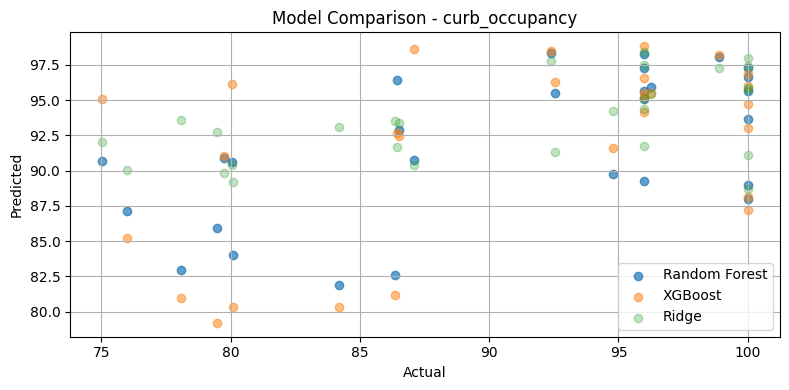


--- Handicap Occupancy Model Evaluation ---

Ridge Regression (handicap_occupancy) Evaluation:
  MAE:       14.59
  RMSE:      24.92
  R²:        0.064
  Accuracy:  85.41%
------------------------------

Random Forest (handicap_occupancy) Evaluation:
  MAE:       11.36
  RMSE:      27.28
  R²:        -0.122
  Accuracy:  88.64%
------------------------------

XGBoost (handicap_occupancy) Evaluation:
  MAE:       14.73
  RMSE:      30.00
  R²:        -0.357
  Accuracy:  85.27%
------------------------------


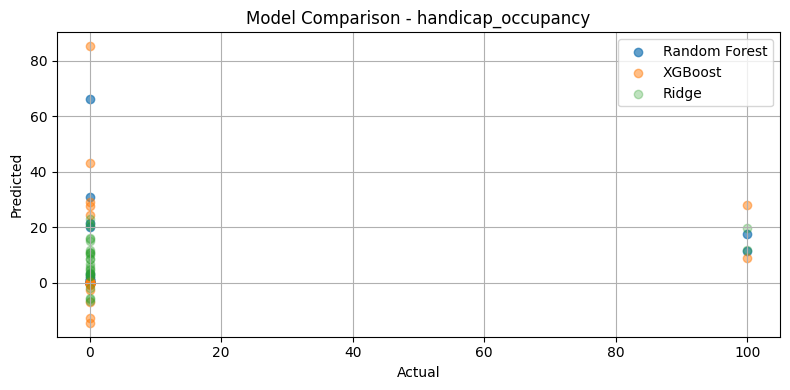

In [15]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

def evaluate_model(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)

    # Safe accuracy calculation
    max_val = max(y_true)
    if max_val == 0:
        accuracy = 0.0
    else:
        accuracy = 100 - (mae / max_val * 100)

    print(f"\n{name} Evaluation:")
    print(f"  MAE:       {mae:.2f}")
    print(f"  RMSE:      {rmse:.2f}")
    print(f"  R²:        {r2:.3f}")
    print(f"  Accuracy:  {accuracy:.2f}%")
    print("-" * 30)

# Training and prediction function for each model

def train_models(df, target_col):
    df = df.dropna(subset=[target_col])
    df = pd.get_dummies(df, columns=['condition'], drop_first=True)

    features = ['hour', 'traffic_congestion', 'temp'] + [col for col in df.columns if col.startswith('condition_')]
    X = df[features]
    y = df[target_col]

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # --- Ridge Regression ---
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    evaluate_model(y_test, y_pred_ridge, f"Ridge Regression ({target_col})")

    # --- Random Forest ---
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    evaluate_model(y_test, y_pred_rf, f"Random Forest ({target_col})")
    joblib.dump(rf, f"rf_{target_col}.pkl")

    # --- XGBoost ---
    xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    evaluate_model(y_test, y_pred_xgb, f"XGBoost ({target_col})")

    # Plotting
    plt.figure(figsize=(8, 4))
    plt.scatter(y_test, y_pred_rf, alpha=0.7, label='Random Forest')
    plt.scatter(y_test, y_pred_xgb, alpha=0.5, label='XGBoost')
    plt.scatter(y_test, y_pred_ridge, alpha=0.3, label='Ridge')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Model Comparison - {target_col}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Apply on both curb and handicap occupancy
selected_lot = final_df['lot_name'].unique()[0]
selected_lot_df = final_df[final_df['lot_name'] == selected_lot].copy()

print("--- Curb Occupancy Model Evaluation ---")
train_models(selected_lot_df.copy(), 'curb_occupancy')

print("\n--- Handicap Occupancy Model Evaluation ---")
train_models(selected_lot_df.copy(), 'handicap_occupancy')

In [16]:
import ipywidgets as widgets
from IPython.display import display, clear_output

In [17]:
# 24-hour forecast function
def forecast_next_24h(df, target_col, model_path):
    df = df.dropna(subset=[target_col])
    df = pd.get_dummies(df, columns=['condition'], drop_first=True)
    features = ['hour', 'traffic_congestion', 'temp'] + [col for col in df.columns if col.startswith('condition_')]
    last_ts = df['ds'].max()
    future_hours = [(last_ts + timedelta(hours=i)).hour for i in range(1, 25)]
    base_row = df.iloc[-1:][features].copy().reset_index(drop=True)
    future_df = pd.concat([base_row] * 24, ignore_index=True)
    future_df['hour'] = future_hours

    model = joblib.load(model_path)

    # Align features
    expected_features = model.feature_names_in_
    for col in expected_features:
        if col not in future_df.columns:
            future_df[col] = 0
    future_df = future_df[expected_features]

    preds = model.predict(future_df)
    status = ["Not Available" if val >= 95 else "Available" for val in preds]
    timestamps = [last_ts + timedelta(hours=i) for i in range(1, 25)]
    result_df = pd.DataFrame({
        'timestamp': timestamps,
        f'{target_col}_prediction': preds,
        f'{target_col}_availability': status
    })
    return result_df

In [18]:
# Dashboard to select target column and lot, and display availability
def interactive_availability_dashboard(df):
    target_dropdown = widgets.Dropdown(
        options=['curb_occupancy', 'handicap_occupancy'],
        description='Occupancy Type:',
        layout=widgets.Layout(width='50%')
    )
    lot_dropdown = widgets.Dropdown(
        options=sorted(df['lot_name'].dropna().unique().tolist()),
        description='Parking Lot:',
        layout=widgets.Layout(width='50%')
    )
    output = widgets.Output()

    def update_table(change):
        with output:
            clear_output()
            target_col = target_dropdown.value
            lot_name = lot_dropdown.value
            lot_df = df[df['lot_name'] == lot_name].copy()
            model_file = f"rf_{target_col}.pkl"
            forecast_df = forecast_next_24h(lot_df, target_col, model_file)
            display(forecast_df.style.set_caption(f"{target_col.capitalize()} Forecast for {lot_name}"))

    target_dropdown.observe(update_table, names='value')
    lot_dropdown.observe(update_table, names='value')

    display(widgets.VBox([target_dropdown, lot_dropdown, output]))

In [19]:
interactive_availability_dashboard(final_df)

In [20]:
# Dash Forecast Dashboard for Colab + ngrok
!pip install dash dash-bootstrap-components flask-ngrok --quiet

import pandas as pd
import plotly.express as px
from dash import Dash, dcc, html, Input, Output, dash_table
from flask_ngrok import run_with_ngrok
import joblib

# Assume final_df is already loaded in Colab
df = final_df.copy()
df['timestamp'] = pd.to_datetime(df['ds'])

# Start the Dash app
app = Dash(__name__, external_stylesheets=['https://stackpath.bootstrapcdn.com/bootstrap/4.5.2/css/bootstrap.min.css'])
run_with_ngrok(app)

app.layout = html.Div([
    html.H2("📊 Parking Occupancy Forecast Dashboard", className='text-center mt-3'),

    html.Div([
        html.Div([
            html.Label("Select Occupancy Type:"),
            dcc.Dropdown(
                id='target-dropdown',
                options=[
                    {'label': 'Curb Occupancy', 'value': 'curb_occupancy'},
                    {'label': 'Handicap Occupancy', 'value': 'handicap_occupancy'}
                ],
                value='curb_occupancy',
                style={'width': '100%'}
            )
        ], className='col-md-4'),

        html.Div([
            html.Label("Select Parking Lot:"),
            dcc.Dropdown(
                id='lot-dropdown',
                options=[{'label': name, 'value': name} for name in sorted(df['lot_name'].unique())],
                value=df['lot_name'].unique()[0],
                style={'width': '100%'}
            )
        ], className='col-md-6')

    ], className='row px-3'),

    html.Br(),
    dcc.Tabs(id='tabs', value='table', children=[
        dcc.Tab(label='Forecast Table', value='table'),
        dcc.Tab(label='Occupancy Chart', value='chart')
    ]),
    html.Div(id='tab-output')
])


@app.callback(
    Output('tab-output', 'children'),
    Input('target-dropdown', 'value'),
    Input('lot-dropdown', 'value'),
    Input('tabs', 'value')
)
def update_output(target_col, lot_name, tab):
    lot_df = df[df['lot_name'] == lot_name].copy()
    model = joblib.load(f'rf_{target_col}.pkl')

    # Prepare future data (reused logic)
    lot_df = pd.get_dummies(lot_df, columns=['condition'], drop_first=True)
    features = ['hour', 'traffic_congestion', 'temp'] + [c for c in lot_df.columns if c.startswith('condition_')]
    last_ts = lot_df['timestamp'].max()
    base_row = lot_df.iloc[-1:][features].copy().reset_index(drop=True)
    future_df = pd.concat([base_row] * 24, ignore_index=True)
    future_df['hour'] = [(last_ts + pd.Timedelta(hours=i)).hour for i in range(1, 25)]

    # Align features
    for col in model.feature_names_in_:
        if col not in future_df.columns:
            future_df[col] = 0
    future_df = future_df[model.feature_names_in_]

    preds = model.predict(future_df)
    availability = ['Available' if val < 95 else 'Not Available' for val in preds]
    timestamps = [last_ts + pd.Timedelta(hours=i) for i in range(1, 25)]

    result_df = pd.DataFrame({
        'timestamp': timestamps,
        'prediction': preds,
        'availability': availability
    })

    if tab == 'table':
        return dash_table.DataTable(
            columns=[{"name": i, "id": i} for i in result_df.columns],
            data=result_df.to_dict('records'),
            style_data_conditional=[
                {
                    'if': {'filter_query': '{availability} = "Available"'},
                    'backgroundColor': '#d4edda',
                    'color': 'black'
                },
                {
                    'if': {'filter_query': '{availability} = "Not Available"'},
                    'backgroundColor': '#f8d7da',
                    'color': 'black'
                }
            ],
            style_table={'overflowX': 'auto'},
            style_cell={'textAlign': 'center'},
            page_size=24
        )
    elif tab == 'chart':
        fig = px.line(result_df, x='timestamp', y='prediction', color='availability',
                      markers=True, title=f"24-Hour {target_col.replace('_',' ').title()} Forecast")
        return dcc.Graph(figure=fig)


app.run()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 15.7 MB/s eta 0:00:00


<IPython.core.display.Javascript object>